<a href="https://colab.research.google.com/github/pranavvedula/neuroflux/blob/main/neuroflux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download and Unzip the Dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:36<00:00, 168MB/s]
100% 4.16G/4.16G [00:36<00:00, 122MB/s]


In [ ]:
! unzip brats20-dataset-training-validation.zip

# 2. Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Not Tumor (NT) volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

The images are in the .nii format. These scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image provides a digital representation of a 3D object, such as a brain in our case.

# 3. Importing Libraries and Exploring the Dataset

In [ ]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [ ]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [ ]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File has been re-named successfully!


In [ ]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


As we can see the maximum pixel value of the image is `1854.6` which gives us a good idea to rescale these values. Rescaling standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Scale the test_image_flair array and then reshape it back to its original dimensions to normalize/standardize model input without altering its spatial structure
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

We will focus on two image modalities to get different perspectives of the MRI scans

1. **Post-contrast T1-weighted (T1ce, also known as T1Gd):** Reveals the structure and composition of tissues and is enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
2. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** This technique suppresses the fluid signals, making it easier to identify lesions, particularly those in the brain's white matter, which are challenging to spot with other scans

Slice Number: 95


Text(0.5, 1.0, 'FLAIR')

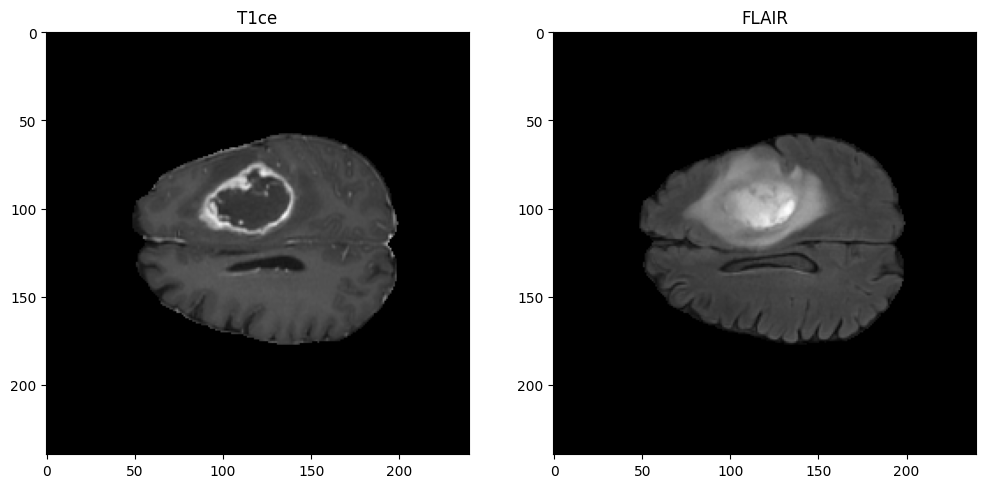

In [ ]:
slice = 95
print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1ce
plt.subplot(1, 2, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# Flair
plt.subplot(1, 2, 2)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

To gain a better understanding of the data structure, let's examine the shape of a modality scan and a segmentation mask. Note that in this dataset, all modalities and their corresponding segmentation masks share the same dimensions:

In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. The 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body.

Here is a quick presentation of these 3 planes:

1. **Axial (Transverse) Plane:** This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. **Coronal (Frontal) Plane:** This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. **Sagittal (Lateral) Plane:** This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Slice number: 95


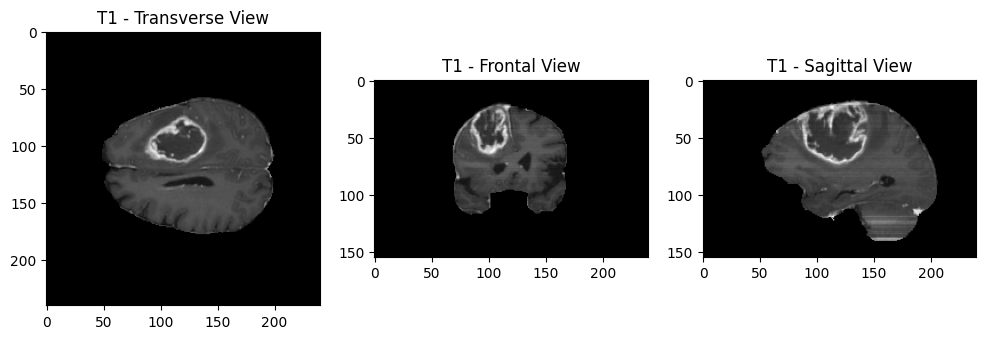

In [ ]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

Looking at what each slice has to offer, we will skip slices 50:-50, where there is not much information

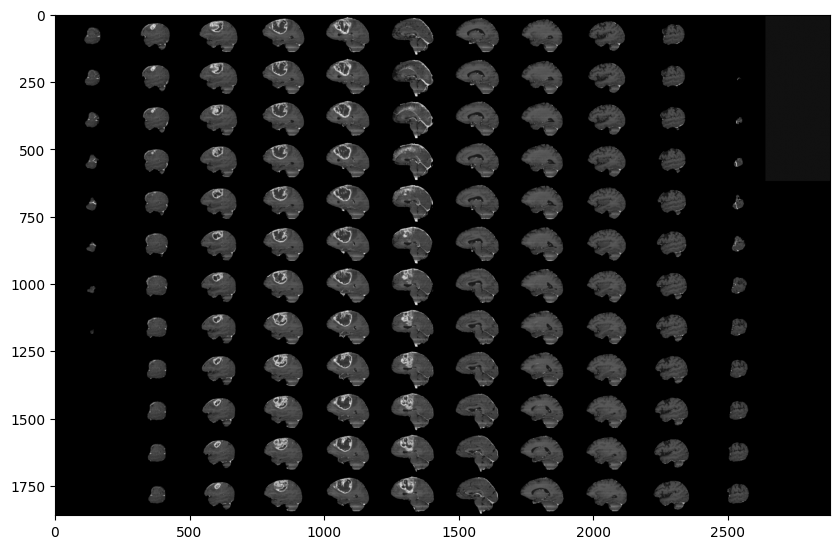

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

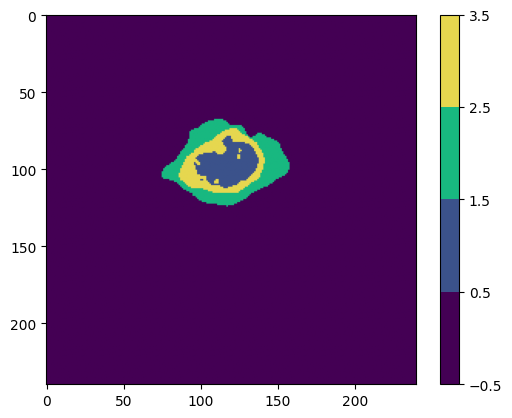

In [ ]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

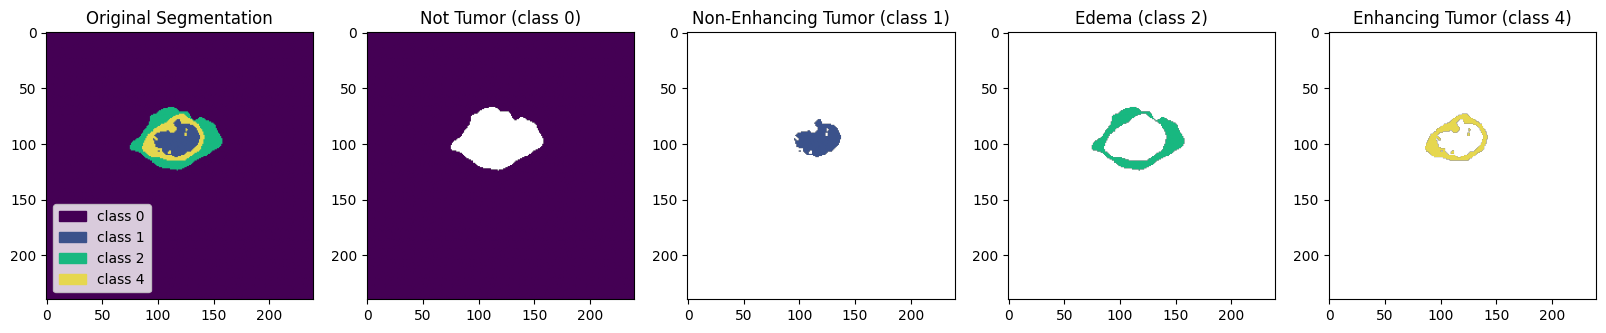

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

These insights are essential for accurate diagnosis, treatment planning, and monitoring. The segmentations help visualize the tumor clearly, making it easier to understand its characteristics and interactions with surrounding tissues.

# 4. Split the Dataset

To train and evaluate our model effectively, we need to split our dataset into three parts: the training set (70-80%) for training the model, the validation set (10-15%) for tuning hyperparameters and preventing overfitting, and the test set (10-15%) for evaluating the final model's performance. We can use random splitting to divide the data or stratified splitting to maintain the same class distribution across sets, which is particularly useful for imbalanced datasets. Properly splitting the dataset ensures that our model is robust and performs well on unseen data.

In [ ]:
# Lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


# 5. DataGenerator


To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. We use a Data Generator for image preprocessing, which includes several steps:

1. **Retrieve paths:** Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. **Load data:** Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. **Create arrays:** Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. **Class reassignment:** Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:

- **Axial plane:** Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
- **One-Hot Encoding:** Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes.
<br>
- **Resize images:** Resize each slice from (240x240) to (128x128). This shape fits well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

In [ ]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

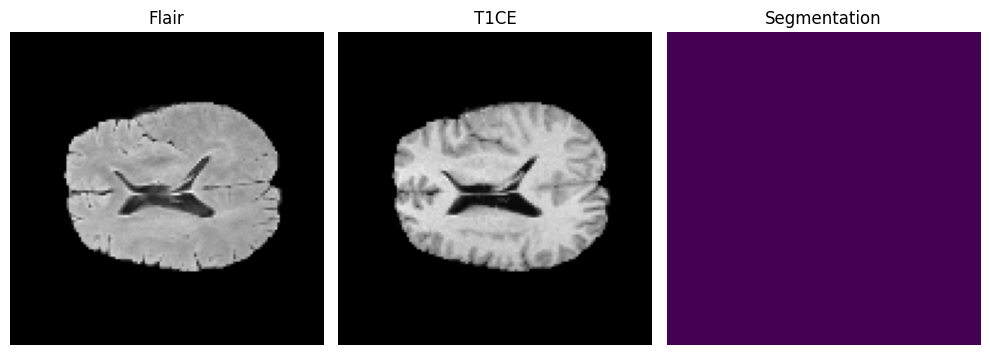

In [ ]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


# 6. Loss Function and Evaluation Metrics

The loss function we decided to use is **categorical cross-entropy**. This function measures the difference between the predicted probability distribution of each pixel and the one-hot encoded ground truth values. Additionally, segmentation models sometimes use the **Dice loss function**, which focuses on the overlap between the predicted and actual segments, further refining the accuracy of the segmentation.

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.keras.backend.flatten(y_true[:, :, :, i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:, :, :, i])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

Per class dice coefficient functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

- **dice_coef_necrotic:** Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.
  
- **dice_coef_edema:** Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.
  
- **dice_coef_enhancing:** Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [ ]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[:,:,:,3])) + epsilon)

To effectively monitor the model's performance, we use various evaluation metrics:

- **Accuracy:** Measures the overall proportion of correctly classified pixels. However, it can be misleading with imbalanced datasets like BraTS2020, where the background class is overrepresented.
- **Intersection over Union (IoU):** Measures the overlap between the predicted and ground truth segmentations.
- **Dice Coefficient:** Evaluates the similarity between predicted and ground truth segmentations.
- **Sensitivity (Recall or True Positive Rate):** Measures the proportion of positive ground truth pixels correctly predicted as positive.
- **Precision (Positive Predictive Value):** Measures the proportion of predicted positive pixels that are actually positive.
- **Specificity (True Negative Rate):** Measures the proportion of negative ground truth pixels correctly predicted as negative.

In [ ]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# 7. The Segmentation Model

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation.

Our dataset consists of 3D images comprised of 2D slices, so we can choose between a 3D and 2D U-net. We will opt for a 2D U-Net, which has slightly worse performance but requires much less computational resources.

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

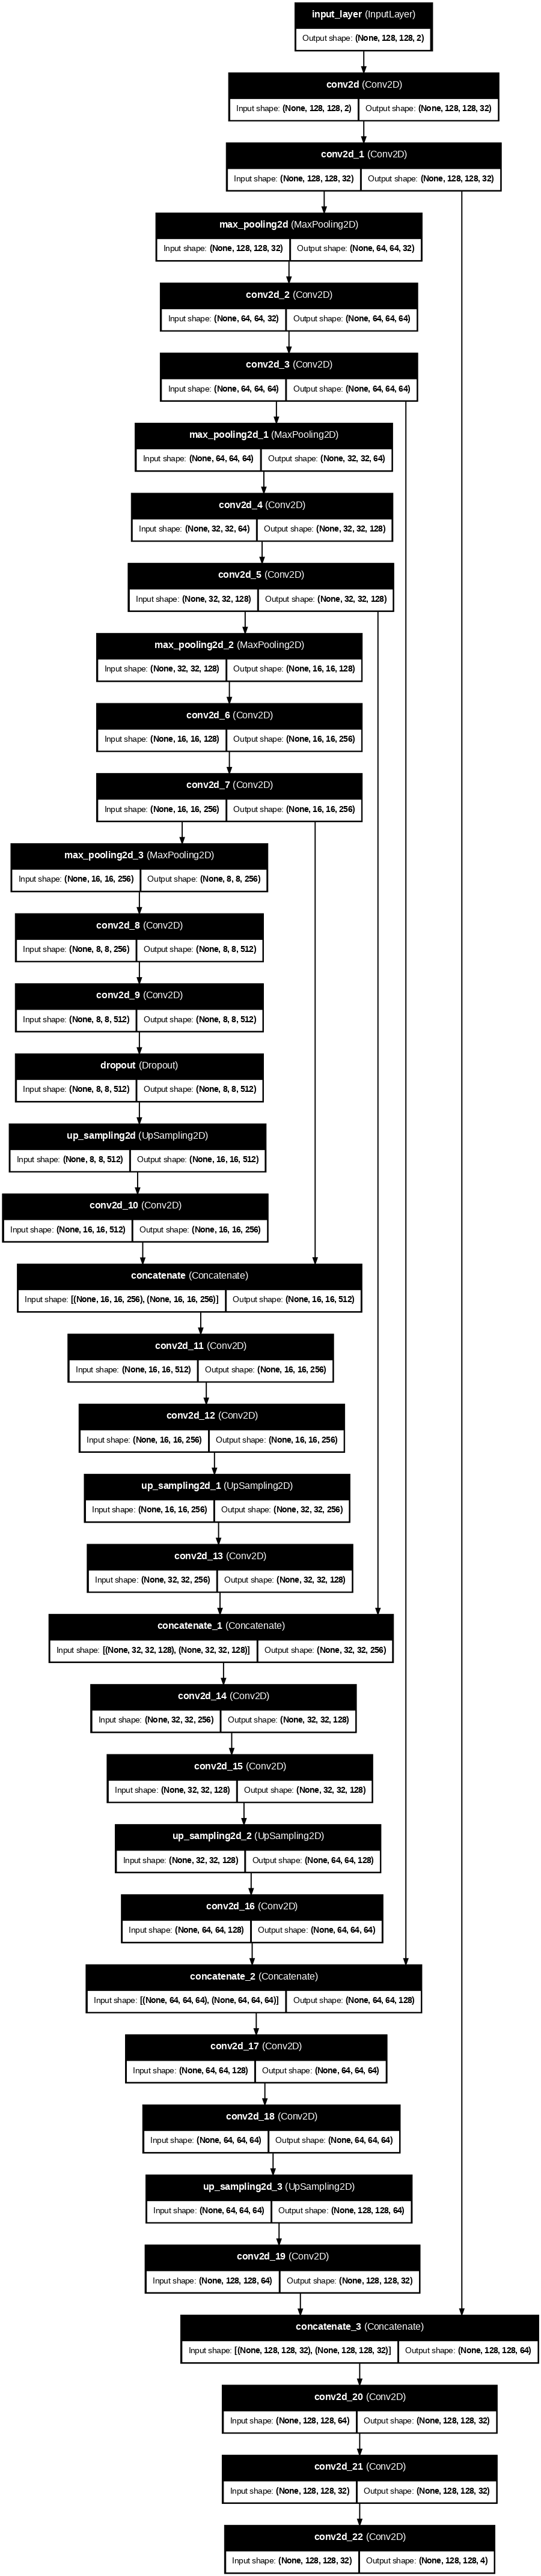

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_.weights.h5',  # Updated extension
        verbose=1, save_best_only=True, save_weights_only=True
    ),
    keras.callbacks.CSVLogger('training.log', separator=',', append=False)
]

# 8. Train and Save the Model

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 25 epochs.

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=25,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9658 - dice_coef: 0.2496 - dice_coef_edema: 0.0804 - dice_coef_enhancing: 0.0294 - dice_coef_necrotic: 0.0324 - loss: 0.2476 - mean_io_u: 0.5442 - precision: 0.9577 - sensitivity: 0.9337 - specificity: 0.9945
Epoch 1: val_loss improved from inf to 0.07658, saving model to model_.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 245s 749ms/step - accuracy: 0.9658 - dice_coef: 0.2497 - dice_coef_edema: 0.0805 - dice_coef_enhancing: 0.0294 - dice_coef_necrotic: 0.0325 - loss: 0.2471 - mean_io_u: 0.5444 - precision: 0.9578 - sensitivity: 0.9338 - specificity: 0.9945 - val_accuracy: 0.9833 - val_dice_coef: 0.2754 - val_dice_coef_edema: 0.1655 - val_dice_coef_enhancing: 0.0662 - val_dice_coef_necrotic: 0.0847 - val_loss: 0.0766 - val_mean_io_u: 0.5836 - val_precision: 0.9830 - val_sensitivity: 0.9831 - val_specificity: 0.9944 - learning_rate: 0.0010
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9833 - dice_coef: 

In [ ]:
model.save("my_model.keras")

# 9. Load the Trained Model

We will load our trained neural network model using Keras. The `load_model` method allows us to reload the saved model, including custom metrics and loss functions we defined during training

In [ ]:
model = keras.models.load_model('/content/my_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

We specify the path to our saved model and provide a dictionary of `custom_objects` to ensure that our custom metrics and loss functions are correctly recognized by Keras. Setting `compile=False` allows us to load the model architecture and weights without compiling it immediately, giving us the flexibility to adjust compilation settings if needed.

# 10. Predict Tumor Segmentations

In [ ]:
# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('model_.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


This allows you to select and use the optimal model version for your specific needs.

In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


<Figure size 1800x5000 with 0 Axes>

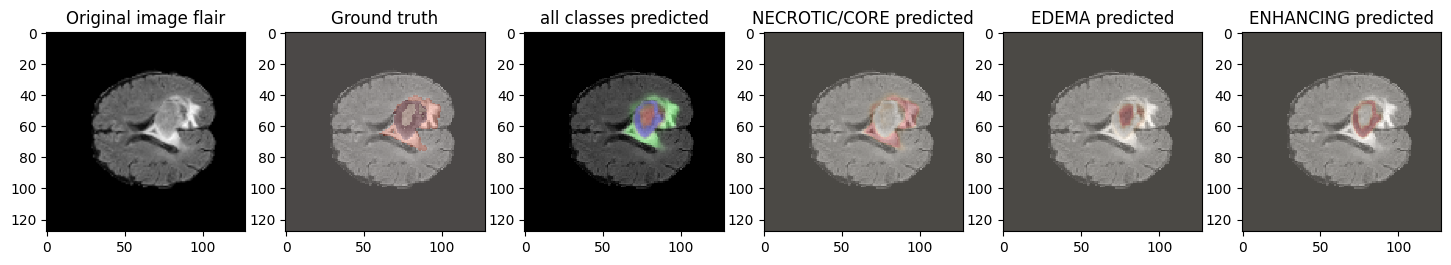

In [ ]:
showPredictsById(case=test_ids[0][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


<Figure size 1800x5000 with 0 Axes>

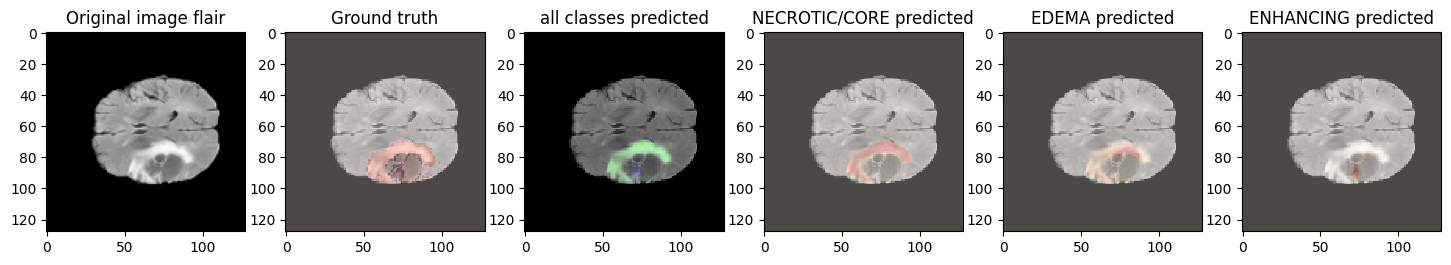

In [ ]:
showPredictsById(case=test_ids[1][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step


<Figure size 1800x5000 with 0 Axes>

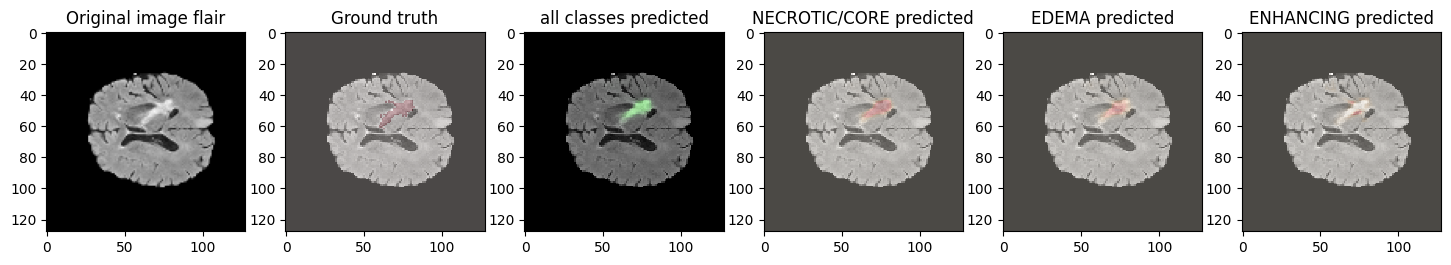

In [ ]:
showPredictsById(case=test_ids[2][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<Figure size 1800x5000 with 0 Axes>

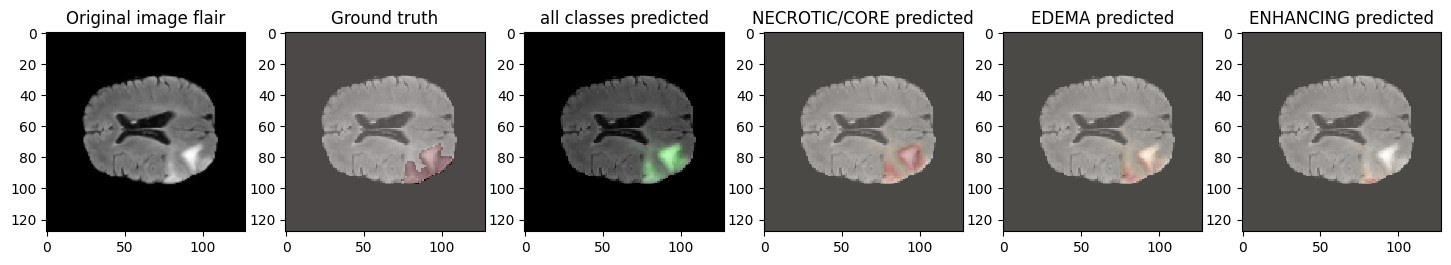

In [ ]:
showPredictsById(case=test_ids[3][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

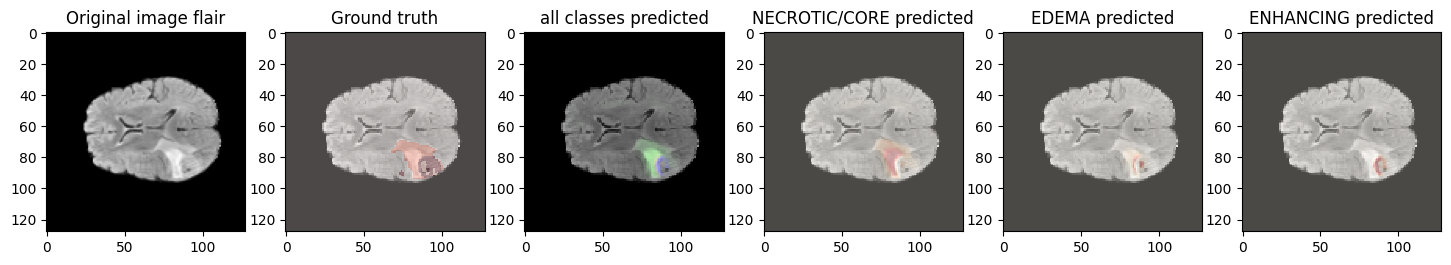

In [ ]:
showPredictsById(case=test_ids[4][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


<Figure size 1800x5000 with 0 Axes>

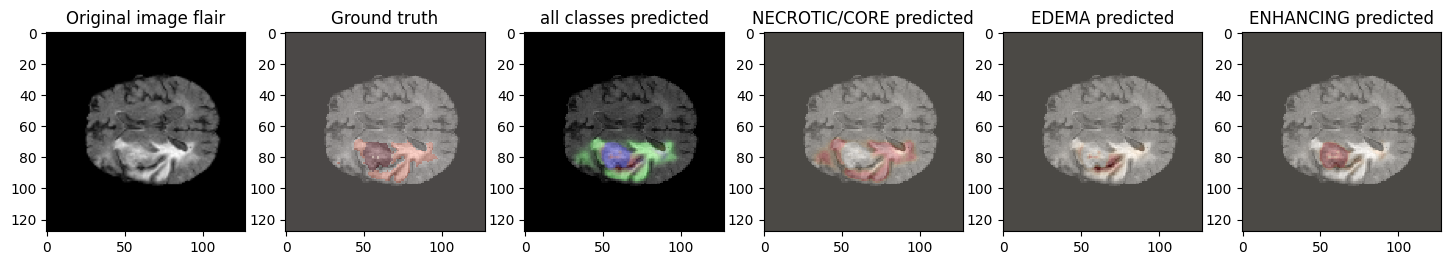

In [ ]:
showPredictsById(case=test_ids[5][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

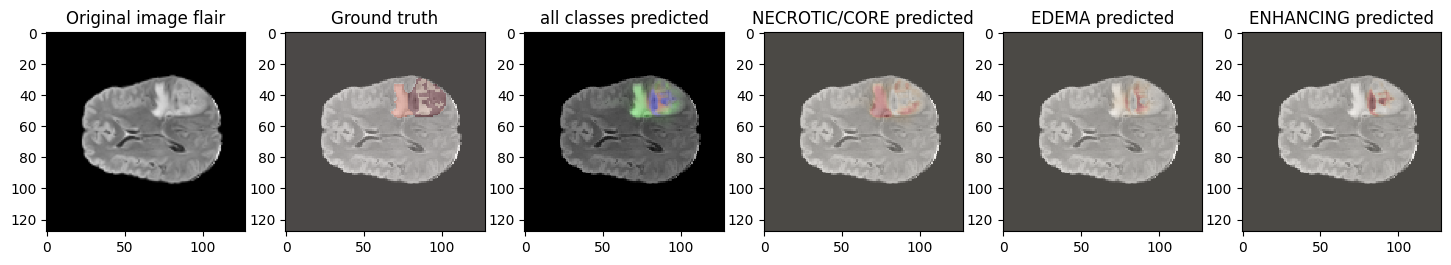

In [ ]:
showPredictsById(case=test_ids[6][-3:])

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Patient number:  BraTS20_Training_312


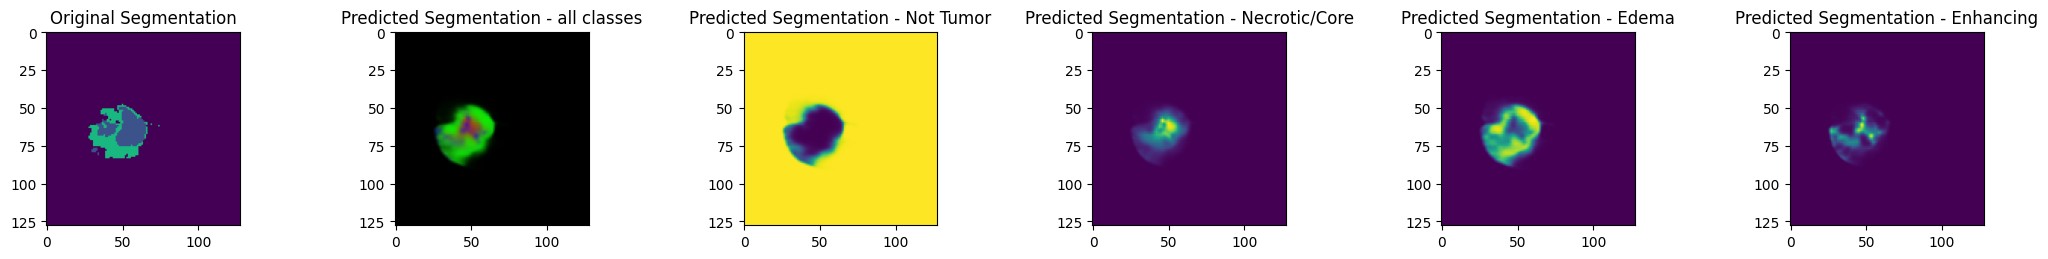

In [ ]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Patient number:  BraTS20_Training_149


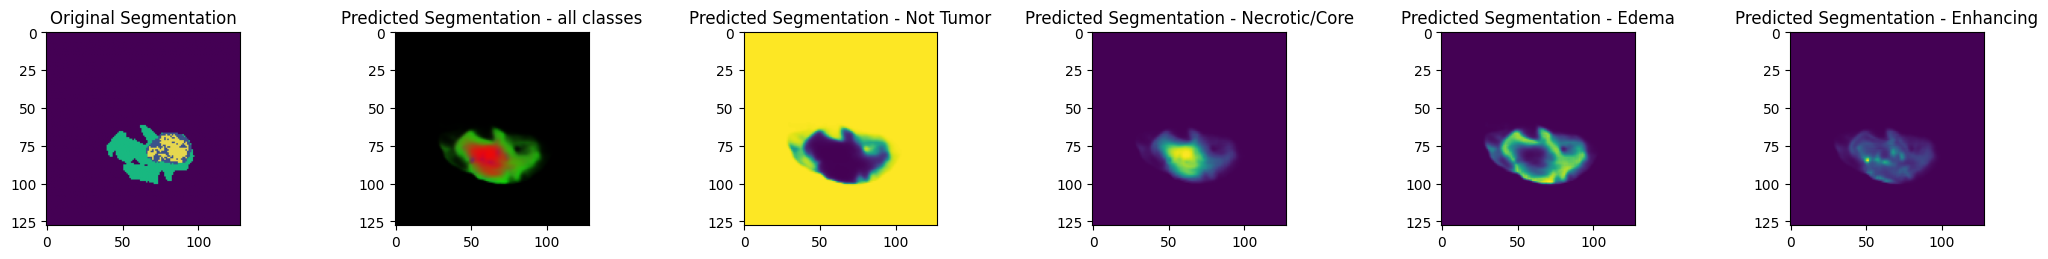

In [ ]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Patient number:  BraTS20_Training_020


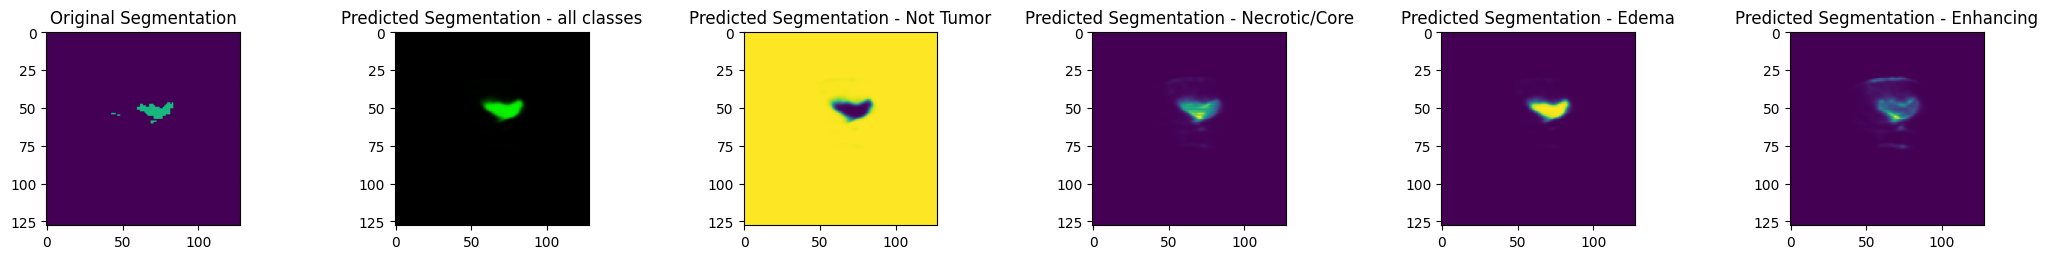

In [ ]:
show_predicted_segmentations(test_ids, 65, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


<Figure size 640x480 with 0 Axes>

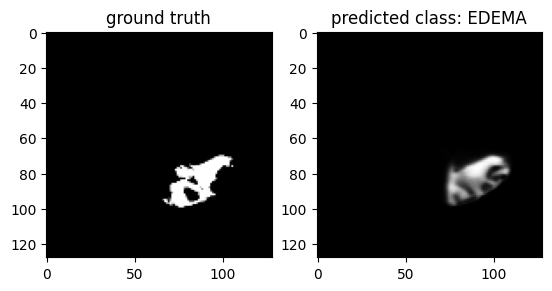

In [ ]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

# 11. Evaluation

Let's call the `evaluate()` function to evaluate the performance of our model on our test dataset:

In [ ]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.9915 - dice_coef: 0.6006 - dice_coef_edema: 0.7298 - dice_coef_enhancing: 0.6969 - dice_coef_necrotic: 0.5261 - loss: 0.0257 - mean_io_u_6: 0.6127 - precision: 0.9923 - sensitivity: 0.9898 - specificity: 0.9974

Model evaluation on the test set:
Loss : 0.0319
Accuracy : 0.9901
MeanIOU : 0.6165
Dice coefficient : 0.5615
Precision : 0.9911
Sensitivity : 0.9885
Specificity : 0.997
Dice coef Necrotic : 0.4347
Dice coef Edema : 0.6882
Dice coef Enhancing : 0.6267


The final evaluation of our model on the test set yields impressive results, demonstrating its effectiveness in segmenting brain tumors.

These metrics indicate that our model performs exceptionally well across various evaluation criteria:

- **Accuracy and Precision** are both above 99%, showcasing the model’s reliability in correctly identifying tumor and non-tumor regions.
- **Mean IoU** of 0.6165 and **Dice Coefficient** of 0.5615 highlight strong overlap between predicted and actual segmentations.
- **Sensitivity** of 0.9885 and **Specificity** of 0.9970 emphasize the model’s capability to correctly identify true positives and true negatives.
- Specific Dice Coefficients for necrotic (0.4347), edema (0.6882), and enhancing (0.6267) regions reflect good performance in segmenting different tumor components.

Overall, these results demonstrate that our model has robust generalization capabilities and can effectively segment brain tumors in unseen data.

# 12. Grad-CAM Implementation

In [ ]:
# Step 1: Locate and Specify the Target Layer
target_layer_name = 'conv5'  # This should be the bottleneck layer of the U-Net model

# Step 2: Define the Grad-CAM function
def get_gradcam_heatmap(model, input_image, target_class_idx, target_layer_name):
    """
    Generate Grad-CAM heatmap for U-Net model

    Parameters:
    - model: Trained U-Net model
    - input_image: Preprocessed input image to generate Grad-CAM for
    - target_class_idx: Index of the target class for which the heatmap is generated
    - target_layer_name: Name of the target convolutional layer for Grad-CAM

    Returns:
    - heatmap: Grad-CAM heatmap
    """

    # Create a model that maps the input image to the activations of the target layer
    target_layer = model.get_layer(target_layer_name)
    grad_model = Model(inputs=[model.inputs],
                       outputs=[target_layer.output, model.output])

    with tf.GradientTape() as tape:
        # Forward pass through the model
        conv_output, predictions = grad_model(input_image)

        # Extract the target class scores
        target_class = predictions[..., target_class_idx]  # Only the target class is focused on

    # Compute the gradient of the target class with respect to the output feature map of the conv layer
    grads = tape.gradient(target_class, conv_output)

    # Compute the mean of the gradients over the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the mean of the gradients
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Step 3: Define a Function to Display the Grad-CAM Heatmap

def display_gradcam_heatmap(input_image, heatmap, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on the original image.

    Parameters:
    - input_image: Original input image for overlay.
    - heatmap: Grad-CAM heatmap to overlay.
    - alpha: Transparency level for the heatmap overlay.
    """

    plt.imshow(input_image, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # Overlay heatmap
    plt.axis('off')
    plt.show()

In [ ]:
def prepare_gradcam_input(case_path, case, slice_num):
    """
    Prepare an input image for Grad-CAM by loading a specific slice from the MRI volumes

    Parameters:
    - case_path: Path to the base directory containing the case folder (e.g., "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/")
    - case: Case identifier (e.g., "355")
    - slice_num: The specific slice number to process and visualize

    Returns:
    - input_image: The processed input image with shape (1, IMG_SIZE, IMG_SIZE, 2)
    """

    # Construct full paths for FLAIR and T1ce images
    case_folder = f'BraTS20_Training_{case}'  # Folder for the specific case
    flair_path = os.path.join(case_path, case_folder, f'{case_folder}_flair.nii')
    t1ce_path = os.path.join(case_path, case_folder, f'{case_folder}_t1ce.nii')

    # Load the FLAIR and T1ce images for the specific slice
    flair_img = nib.load(flair_path).get_fdata()[:, :, slice_num]
    t1ce_img = nib.load(t1ce_path).get_fdata()[:, :, slice_num]

    # Resize and normalize the slices to match the model's expected input size
    flair_img_resized = cv2.resize(flair_img, (IMG_SIZE, IMG_SIZE)) / np.max(flair_img)
    t1ce_img_resized = cv2.resize(t1ce_img, (IMG_SIZE, IMG_SIZE)) / np.max(t1ce_img)

    # Stack and expand dimensions to match model input shape
    input_image = np.stack([flair_img_resized, t1ce_img_resized], axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Shape becomes (1, IMG_SIZE, IMG_SIZE, 2)
    return input_image

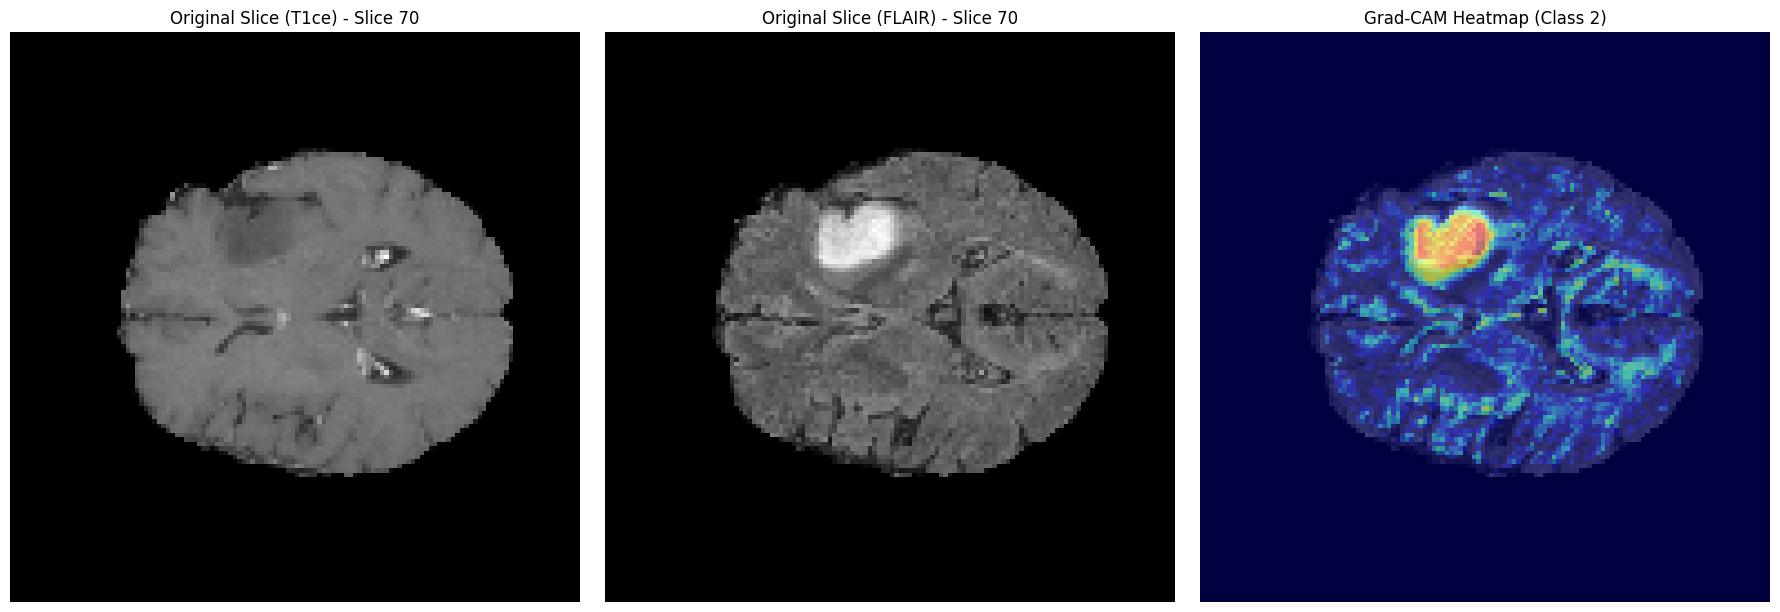

In [ ]:
def gradcam_visualization(case, slice_num, target_class_idx):
    """
    Creates a side-by-side of the original MRI scan and the scan visualized with Grad-CAM.

    Parameters:
    - case: Case identifier (e.g., "355")
    - slice_num: The slice number to visualize
    - target_class_idx: Target class index (e.g., "Necrotic")

    Returns:
    - input_image: The processed input image with shape (1, IMG_SIZE, IMG_SIZE, 2).
    """
    case_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

    # Prepare the input image
    input_image = prepare_gradcam_input(case_path, case, slice_num)

    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(model, input_image, target_class_idx, target_layer_name="conv2d_1")

    # Visualization
    plt.figure(figsize=(18, 6))

    # Display the original slice (T1CE channel) on the left
    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0, :, :, 1], cmap='gray')  # FLAIR channel
    plt.title(f'Original Slice (T1ce) - Slice {slice_num}')
    plt.axis('off')

    # Display the original slice (FLAIR channel) on the left
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, :, :, 0], cmap='gray')  # FLAIR channel
    plt.title(f'Original Slice (FLAIR) - Slice {slice_num}')
    plt.axis('off')

    # Display the Grad-CAM heatmap overlay on the right
    plt.subplot(1, 3, 3)
    plt.imshow(input_image[0, :, :, 0], cmap='gray')  # FLAIR channel
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Grad-CAM overlay
    plt.title(f'Grad-CAM Heatmap (Class {target_class_idx})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
gradcam_visualization(case='200', slice_num=70, target_class_idx=2)

<ipython-input-84-3916adffd0b8>:24: RuntimeWarning: invalid value encountered in divide
  flair_img_resized = cv2.resize(flair_img, (IMG_SIZE, IMG_SIZE)) / np.max(flair_img)
<ipython-input-84-3916adffd0b8>:25: RuntimeWarning: invalid value encountered in divide
  t1ce_img_resized = cv2.resize(t1ce_img, (IMG_SIZE, IMG_SIZE)) / np.max(t1ce_img)


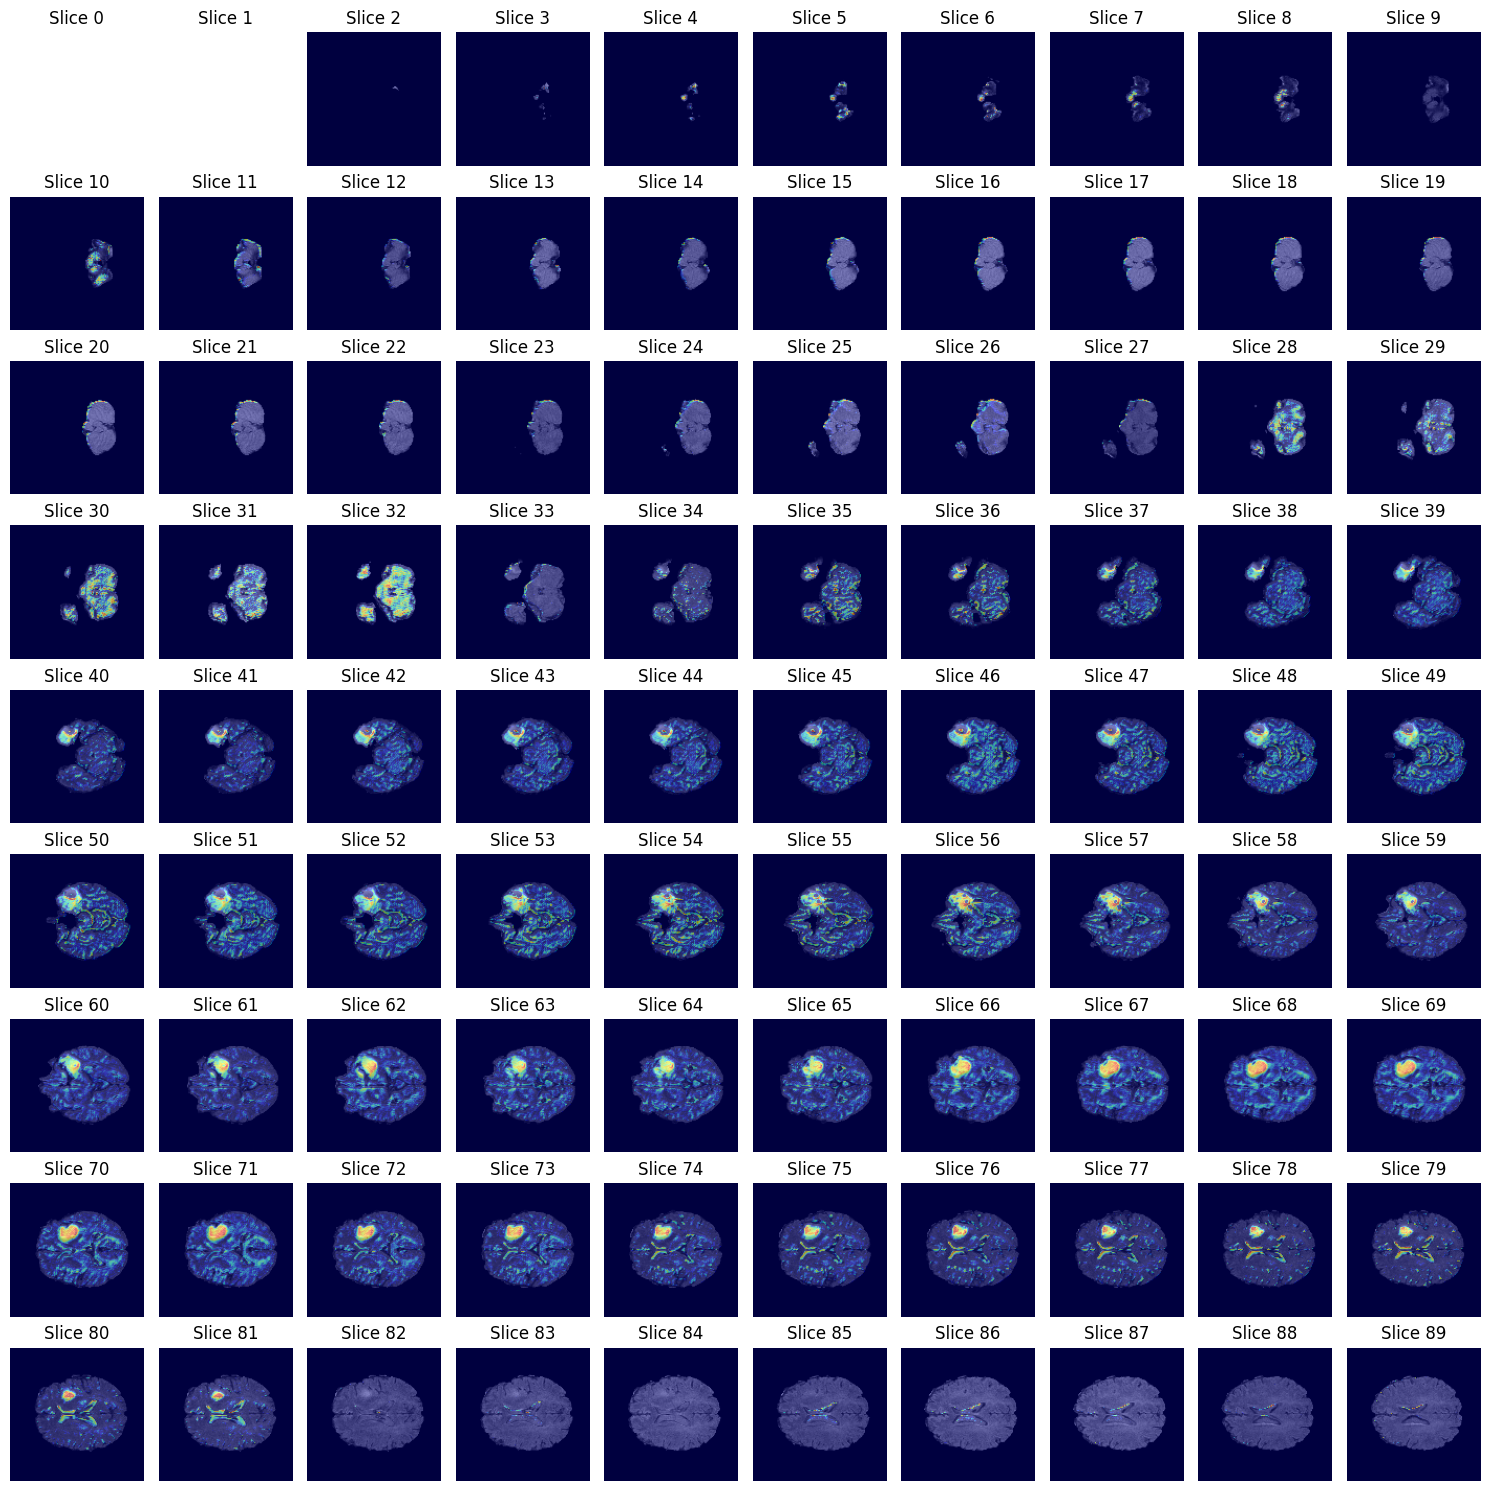

In [ ]:
def display_heatmaps_in_grid(case_path, case, num_slices, rows, cols, model, target_class_idx, target_layer_name="conv2d_1"):
    """
    Generate and display Grad-CAM heatmaps for slices in a grid pattern.

    Args:
        case_path (str): Path to the input case.
        case (str): Case name.
        num_slices (int): Number of slices to display.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        model: The trained model used for Grad-CAM generation.
        target_class_idx (int): Target class index for Grad-CAM.
        target_layer_name (str): Name of the target layer for Grad-CAM.
    """

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust figure size as needed
    axes = axes.flatten()

    for i, ax in enumerate(axes[:num_slices]):  # Ensure we don't exceed the grid capacity
        # Select the slice number
        slice_num = i

        # Prepare the input image
        input_image = prepare_gradcam_input(case_path, case, slice_num)

        # Generate Grad-CAM heatmap
        heatmap = get_gradcam_heatmap(model, input_image, target_class_idx, target_layer_name)

        # Display the heatmap overlay on the original slice
        ax.imshow(input_image[0, :, :, 0], cmap="gray")  # Original slice in grayscale
        ax.imshow(heatmap, cmap="jet", alpha=0.5)  # Heatmap overlay
        ax.axis("off")
        ax.set_title(f"Slice {slice_num}")

    # Hide any remaining empty subplots
    for ax in axes[num_slices:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
case_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
case = "200"
num_slices = 155  # Total number of slices
rows, cols = 9, 10  # Grid shape (9 rows x 10 columns)
target_class_idx = 2  # Modify based on your use case

# Call the function to generate and display the grid of Grad-CAM heatmaps
display_heatmaps_in_grid(case_path, case, num_slices, rows, cols, model, target_class_idx, target_layer_name="conv2d_1")


# 13. Conclusion

This notebook demonstrates the process of training and evaluating a neural network for brain tumor segmentation using the BraTS2020 dataset. We explored data preprocessing techniques, employed the U-Net architecture, and utilized various evaluation metrics to ensure robust model performance.

Finally, we implemented Grad-CAM to highlight the parts of a scan that highly influenced the model's decision. This contributes to the transparency of the model and is extremely useful for doctors and researchers trying to interpret an algorithm's output.